In [110]:
import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(1,100,100)
dz = np.tanh(t/100*np.pi)

z0 = np.flip(np.cumsum(dz))
z_true = np.tile(z0,(10,1)) + np.expand_dims(np.linspace(1,10,10),1)

noise = np.random.normal(size=z_true.shape)
valid_mask = np.random.uniform(size=z_true.shape)<0.8
z_obs = np.where(valid_mask, z_true + noise, 0)

In [101]:
import sys
from pathlib import Path

src = str(Path('../src').resolve())
if src not in sys.path:
    sys.path.append(src)
    
from models.transformer import DynamicEmbedder, TransformerLayer

In [132]:
import equinox as eqx
import jax

class small_transformer(eqx.Module):
    embedder: DynamicEmbedder
    layer: TransformerLayer
    head: eqx.nn.Linear
    
    def __init__(self, seq_length, in_size, hidden_size, num_heads, dropout, key):
        keys = jax.random.split(key, 3)
        self.embedder = DynamicEmbedder(seq_length, in_size, hidden_size, dropout, keys[0])
        self.layer = TransformerLayer(hidden_size, hidden_size, num_heads, dropout, keys[1])
        self.head = eqx.nn.Linear(hidden_size, 1, key=keys[2])
        
    def __call__(self, x, mask, key):
        keys = jax.random.split(key)
        zero_bias = jnp.zeros((x.shape[0], x.shape[0]))
        mask = jnp.tile(mask, (1, x.shape[0]))
        
        embed = self.embedder(x, keys[0])
        attn = self.layer(embed, zero_bias, mask, keys[1])
        final_token = jnp.mean(attn,axis=0)
        return self.head(final_token)
        
key = jax.random.PRNGKey(0)
train_key, model_key = jax.random.split(key)




In [135]:
from tqdm.auto import trange, tqdm
import jax.numpy as jnp
import optax  

@eqx.filter_value_and_grad
def compute_loss(model, x, y, m, keys):
    pred_y = jax.vmap(model)(x, m, keys)
    mse = jnp.sqrt(jnp.mean((y-pred_y)**2))
    return mse

@eqx.filter_jit
def make_step(model, x, y, m, opt_state, keys):
    loss, grads = compute_loss(model, x, y, m, keys)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state


seq_length = 90
hidden_size = 64
model = small_transformer(seq_length, 1, hidden_size, 1, 0, model_key)


learning_rate=0.0001
epochs = 250
    
optim = optax.adam(learning_rate)
opt_state = optim.init(model)

valid_ids = valid_mask.copy()
valid_ids[:, :seq_length] = 0
valid_id_tuples = [(ids[0],ids[1]) for ids in np.argwhere(valid_ids)]

batch_size = 64
n_batches = len(valid_id_tuples)//batch_size

training_losses = []
rng = np.random.default_rng()
pbar = trange(epochs)
for e in pbar:
    rng.shuffle(valid_id_tuples, axis=0) #in place shuffling
    
    epoch_losses = []
    epoch_ids = valid_id_tuples[:n_batches*batch_size]
    for idx in range(n_batches):
        batch_ids = epoch_ids[idx*batch_size:(idx+1)*batch_size]
        x = [z_obs[loc,t-seq_length:t] for loc, t in batch_ids]
        x = jnp.stack(x)
        x = jnp.expand_dims(x, -1)
        
        m = [valid_mask[loc,t-seq_length:t] for loc, t in batch_ids]
        m = jnp.stack(m)
        m = jnp.expand_dims(m, -1)
        
        y = jnp.array([z_true[loc,t] for loc, t in batch_ids])
        
        keys = jax.random.split(train_key, batch_size+1)
        train_key = keys[0]
        batch_keys = keys[1:] 
        
        loss, model, opt_state = make_step(model, x, y, m, opt_state, batch_keys)
        epoch_losses.append(loss)
    avg_loss = np.mean(np.array(epoch_losses))
    pbar.set_postfix_str(avg_loss)
    training_losses.append(avg_loss)
    

# pred_ys = jax.vmap(model)(xs)
# num_correct = jnp.sum((pred_ys > 0.5) == ys)
# final_accuracy = (num_correct / dataset_size).item()
# print(f"final_accuracy={final_accuracy}")

  0%|          | 0/250 [00:00<?, ?it/s]

In [125]:
x = [z_obs[loc,t-seq_length:t] for loc, t in batch_ids]
x = jnp.stack(x)
x = jnp.expand_dims(x, -1)

m = [valid_mask[loc,t-seq_length:t] for loc, t in batch_ids]
m = jnp.stack(m)
m = jnp.expand_dims(m, -1)

y = jnp.array([z_true[loc,t] for loc, t in batch_ids])

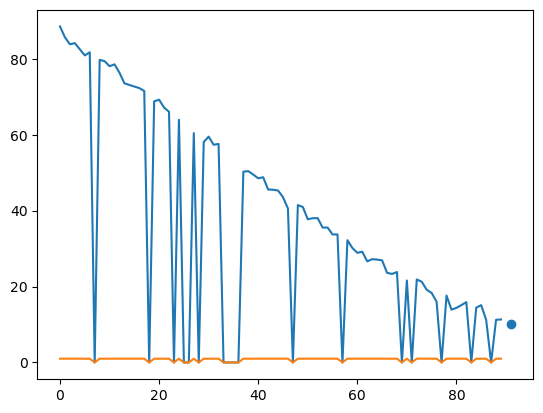

In [136]:
plt.plot(x[2,:,0])
plt.plot(m[2,:,0])
plt.scatter(seq_length+1, y[0])